# Introdução ao Fairlearn
## Link: [https://fairlearn.org/v0.7.0/quickstart.html]()

<br>

# Conjunto de Dados

### [Census Income 1994](https://archive.ics.uci.edu/ml/datasets/Adult), se os indivíduos ultrapassam a receita de 50K dolares por ano.

### 48842 indivíduos: Feminino (16192) e Masculino (32650)

### O sexo é a variável sensível da execução do tutorial!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [2]:
#carregamento dos dados
dados = fetch_openml(data_id=1590, as_frame=True)

#conversão de variáveis
x = pd.get_dummies(dados.data)

#pegando os rotulos dos dados (ganhos de 50K) localizados na variável target do dataframe
y_true = (dados.target=='>50K') * 1

#variável somente com o sexo dos indivíduos do conjunto
sex = dados.data['sex']
sex.value_counts()

Male      32650
Female    16192
Name: sex, dtype: int64

In [3]:
dados.feature_names

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

<AxesSubplot:title={'center':'Quantidade de Indivíduos'}>

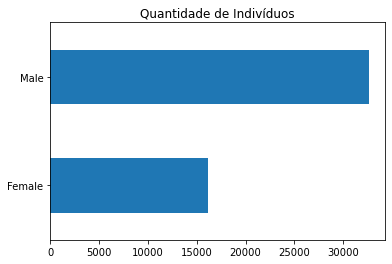

In [4]:
sex.value_counts().sort_values().plot(kind='barh', title='Quantidade de Indivíduos')

# Avaliando métricas relacionadas à Fairness

### O Fairlearn fornece métricas relacionadas à justiça que podem ser comparadas entre grupos e para a população em geral. Usando as definições de métricas existentes do scikit-learn, podemos avaliar as métricas para subgrupos dentro dos dados

In [5]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

In [6]:
#criação, treino e previsão do classificador de árvore de decisão
classificador = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)

classificador.fit(x, y_true)

y_pred = classificador.predict(x)

accuracy_score(y_true, y_pred)

0.8443552680070431

In [7]:
#utilizando fairlearn para calcular acurácia
#função de valores métricos desagregados
acc = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

#acurácia para todos os dados do conjunto, a mesma quando utilizando apenas accuracy_score()
print(acc.overall)
#acurácia calculada para cada classe dos atributos sensíveis passados, nesse caso o sexo
acc.by_group

0.8443552680070431


sex
Female    0.925148
Male      0.804288
Name: accuracy_score, dtype: object

In [8]:
from fairlearn.metrics import selection_rate
#selection rate (taxa de seleção): porcentagem da população que tem '1' como rótulo

sr = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sex)
print(sr.overall)
print(sr.by_group)

0.16385487899758405
sex
Female     0.06355
Male      0.213599
Name: selection_rate, dtype: object


accuracy               0.844355
precision              0.755217
recall                 0.517156
false positive rate    0.052725
true positive rate     0.517156
selection rate         0.163855
count                     48842
dtype: object


,accuracy,precision,recall,false positive rate,true positive rate,selection rate,count
sex,,,,,,,
Female,0.925148,0.770651,0.448276,0.016363,0.448276,0.06355,16192
Male,0.804288,0.752939,0.529441,0.075796,0.529441,0.213599,32650


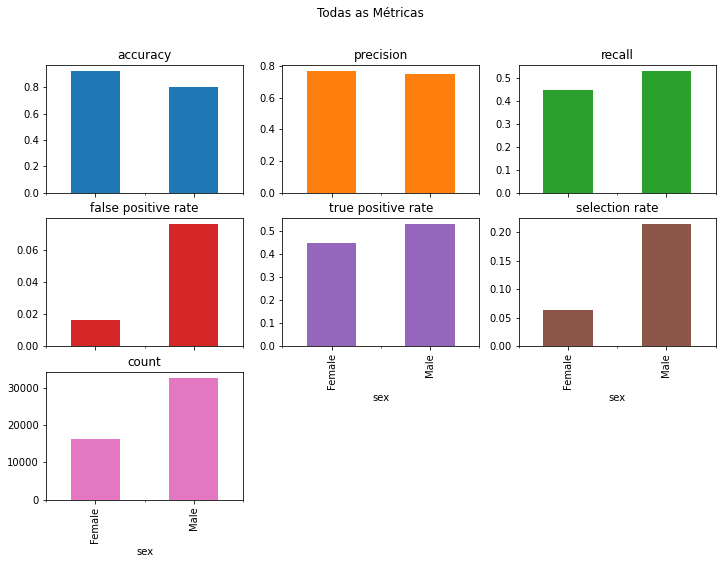

In [9]:
from fairlearn.metrics import false_positive_rate, true_positive_rate, count

#agrupamento de métricas para cálculo com MetricFrame
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'false positive rate': false_positive_rate,
    'true positive rate': true_positive_rate,
    'selection rate': selection_rate,
    'count': count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sex
)

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12,8],
    title="Todas as Métricas"
)

print(metric_frame.overall)
metric_frame.by_group

# Atenuando a Disparidade

### Se observarmos disparidades entre grupos, podemos querer criar um novo modelo enquanto especificamos uma restrição de justiça apropriada. Observe que a escolha das restrições de imparcialidade é crucial para o modelo resultante e varia com base no contexto do aplicativo.

### Se a taxa de seleção for altamente relevante para a justiça neste exemplo inventado, podemos tentar mitigar a disparidade observada usando a restrição de justiça correspondente chamada Paridade Demográfica. A técnica de mitigação de Gradiente Exponenciado usada se encaixa no classificador fornecido usando a Paridade Demográfica como objetivo, levando a uma diferença muito reduzida na taxa de seleção

In [10]:
#utilizando paridade demográfica para uma classificação mais justa
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
np.random.seed(0) #resultados consistentes para o ExponentiatedGradient

### Implementação da Paridade Demográfica, em que classificador h(X) satisfaz paridade demográfica se: P[h(X)=1 | A=a] = P[h(X)=1] Va

In [11]:
paridade_demografica = DemographicParity()

#criação de um segundo classificador de Árvore de Decisão
classificador2 = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)

### O `ExponentiatedGradient` é um estimador que reduz a classificação justa a uma sequência de problemas de classificação sensíveis ao custo, em que as soluções geral um classificador aleatório com o menor erro (empírico) sujeito às restrições desejadas. [Artigo](https://arxiv.org/abs/1803.02453) do estimador

In [12]:
mitigator = ExponentiatedGradient(classificador2, paridade_demografica)

#realizando o treino do modelo justo e utilizando o sexo como atributo sensível
mitigator.fit(x, y_true, sensitive_features=sex)

#previsão dos dados utilizando o modelo justo
y_pred_mitigated = mitigator.predict(x)

In [13]:
#calculando selection rate com os dados mitigados pelo modelo
#atualização: calculando todas as métricas com os dados mitigados pelo modelo
resultado_mitigated = MetricFrame(metrics=metrics, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)

In [14]:
print(resultado_mitigated.overall)
resultado_mitigated.by_group

accuracy               0.820646
precision              0.680345
recall                 0.472405
false positive rate    0.069816
true positive rate     0.472405
selection rate         0.166148
count                     48842
dtype: object


,accuracy,precision,recall,false positive rate,true positive rate,selection rate,count
sex,,,,,,,
Female,0.891737,0.503182,0.715093,0.086598,0.715093,0.155262,16192
Male,0.785391,0.759864,0.429119,0.059168,0.429119,0.171547,32650


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'precision'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'recall'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'false positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'true positive rate'}, xlabel='sex'>,
        <AxesSubplot:title={'center':'selection rate'}, xlabel='sex'>],
       [<AxesSubplot:title={'center':'count'}, xlabel='sex'>,
        <AxesSubplot:xlabel='sex'>, <AxesSubplot:xlabel='sex'>]],
      dtype=object)

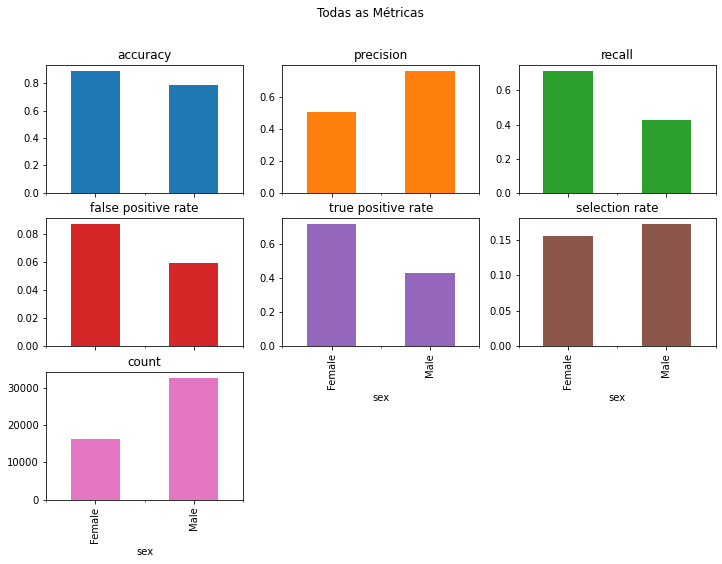

In [15]:
resultado_mitigated.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12,8],
    title="Todas as Métricas"
)

In [16]:
#criando nova variável com o conjunto de dados para exportar e realizar balanceamento
dados_balancear = dados.data
dados_balancear['mais50k'] = y_true
dados_balancear.to_csv('2-dados.csv', index=False)